# DATA PRE-PROCESSING - Advanced study of epigenetic mechanisms in the development of neoplasms 

In this notebook, I will evaluate and define the most appropriate **pre-processing operations** (in the next notebook), also in relation to the thesis work of *Nastaran Ahmadi Bonakdare* and the procedures described in the article “*Early detection and diagnosis of cancer with interpretable machine learning to uncover cancer-specific DNA methylation patterns*” (Izzy Newsham et al., MRC Cancer Unit, University of Cambridge).

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation
import warnings
from scipy.stats import mannwhitneyu
from scipy.stats import gaussian_kde

warnings.filterwarnings('ignore')

### Import dataset 

In [2]:
# Find dataset's path 
file_path = '/kaggle/input/raw-dataset/GSE69914_series_matrix.csv'  # file's path
raw_dataset = pd.read_csv(file_path)

# Delete the first column relating to the CpG index
raw_dataset.set_index('ID_REF', inplace=True)

# I transpose the dataset so that each row represents a sample and each column corresponds to a CpG site (feature)
raw_dataset = raw_dataset.T

## Data Pre-Processing
### Step 1 — Sample Grouping and Label Assignment

As a first preprocessing step, the samples were grouped into three biological categories based on the classification reported on the GEO portal **[1]**, as referenced in Bonakdare’s work. Specifically, the dataset includes 407 samples in total, which were assigned to one of the following groups:

* **0** = Normal
* **1** = Adjacent-normal
* **2** = Tumor

All samples were retained, including those characterized as BRCA1-normal and BRCA1-tumor, which were incorporated into the respective normal and tumor groups for this initial stage. This labeling provides a consistent structure for downstream preprocessing and analysis.

**Open consideration — BRCA1-specific samples:**
A question arises regarding the treatment of BRCA1-positive samples currently embedded within the normal and tumor classes. Given the relatively limited sample size, is it more appropriate to retain these cases within their broader biological groups (as done here), remove them to avoid potential confounding, or define them as separate categories for downstream stratification? For the moment, they have been included in the main classes, with the option of excluding or reclassifying them at a later stage without affecting the current workflow.

- `normal_brca1_samples = ['GSM1712378', 'GSM1712392', 'GSM1712420', 'GSM1712442', 'GSM1712476', 'GSM1712560', 'GSM1712650', 'GSM1712724']`
- `cancer_brca1_samples = ['GSM1712411', 'GSM1712427', 'GSM1712636']`

If batch correction becomes necessary at a later stage, I can retrieve technical batch information from the GEO sample pages (GSM entries). Each GSM record typically includes a ‘Sentrix ID’ or ‘methylation barcode’, which identifies the slide or array on which the sample was processed. These slide-level identifiers can be used to group samples into technical batches. Including such batch covariates in downstream analysis (e.g., during normalization or differential methylation testing) can help remove non-biological variation introduced by processing differences across arrays or time. This step would only be required if exploratory analyses later reveal clustering, bias, or unwanted variability that is not explained by biological groups alone.

In [3]:
# Each sample is assigned a status: normal, adjacent, tumour

# 0 - Normal
normal_samples = [
    'GSM1712369', 'GSM1712385', 'GSM1712398', 'GSM1712412', 'GSM1712419', 'GSM1712423',
    'GSM1712435', 'GSM1712439', 'GSM1712440', 'GSM1712449', 'GSM1712464', 'GSM1712472',
    'GSM1712489', 'GSM1712490', 'GSM1712504', 'GSM1712535', 'GSM1712541', 'GSM1712551',
    'GSM1712565', 'GSM1712566', 'GSM1712574', 'GSM1712578', 'GSM1712583', 'GSM1712598',
    'GSM1712609', 'GSM1712615', 'GSM1712620', 'GSM1712625', 'GSM1712633', 'GSM1712648',
    'GSM1712649', 'GSM1712660', 'GSM1712661', 'GSM1712664', 'GSM1712678', 'GSM1712682',
    'GSM1712683', 'GSM1712693', 'GSM1712700', 'GSM1712713', 'GSM1712721', 'GSM1712723',
    'GSM1712733', 'GSM1712745', 'GSM1712755', 'GSM1712763', 'GSM1712772', 'GSM1712776', 
    'GSM1712378', 'GSM1712392', 'GSM1712420', 'GSM1712442', 'GSM1712476', 'GSM1712560',
    'GSM1712650', 'GSM1712724'
]

# 1 - Adjacent-Normal
adjacent_normal_samples = [
    'GSM1712368', 'GSM1712372', 'GSM1712383', 'GSM1712390', 'GSM1712405', 'GSM1712436',
    'GSM1712450', 'GSM1712457', 'GSM1712465', 'GSM1712466', 'GSM1712473', 'GSM1712475',
    'GSM1712487', 'GSM1712500', 'GSM1712503', 'GSM1712510', 'GSM1712511', 'GSM1712520',
    'GSM1712523', 'GSM1712528', 'GSM1712538', 'GSM1712548', 'GSM1712549', 'GSM1712558',
    'GSM1712572', 'GSM1712581', 'GSM1712595', 'GSM1712597', 'GSM1712606', 'GSM1712610',
    'GSM1712611', 'GSM1712612', 'GSM1712613', 'GSM1712614', 'GSM1712616', 'GSM1712632',
    'GSM1712642', 'GSM1712644', 'GSM1712672', 'GSM1712687', 'GSM1712701', 'GSM1712706',
    'GSM1712708', 'GSM1712727', 'GSM1712737', 'GSM1712739', 'GSM1712743', 'GSM1712752',
    'GSM1712777'
]

# 2 - Breast Cancer
breast_cancer_samples = [
    'GSM1712367', 'GSM1712370', 'GSM1712371', 'GSM1712373', 'GSM1712374', 'GSM1712375',
    'GSM1712376', 'GSM1712377', 'GSM1712379', 'GSM1712380', 'GSM1712382', 'GSM1712381',
    'GSM1712384', 'GSM1712386', 'GSM1712387', 'GSM1712388', 'GSM1712389', 'GSM1712391',
    'GSM1712393', 'GSM1712394', 'GSM1712395', 'GSM1712396', 'GSM1712397', 'GSM1712399',
    'GSM1712400', 'GSM1712401', 'GSM1712402', 'GSM1712403', 'GSM1712404', 'GSM1712406',
    'GSM1712407', 'GSM1712408', 'GSM1712409', 'GSM1712410', 'GSM1712413', 'GSM1712414',
    'GSM1712415', 'GSM1712416', 'GSM1712417', 'GSM1712418', 'GSM1712421', 'GSM1712422',
    'GSM1712424', 'GSM1712425', 'GSM1712426', 'GSM1712428', 'GSM1712429', 'GSM1712430',
    'GSM1712431', 'GSM1712432', 'GSM1712433', 'GSM1712434', 'GSM1712437', 'GSM1712438',
    'GSM1712441', 'GSM1712443', 'GSM1712444', 'GSM1712445', 'GSM1712446', 'GSM1712447',
    'GSM1712448', 'GSM1712451', 'GSM1712452', 'GSM1712453', 'GSM1712454', 'GSM1712455',
    'GSM1712456', 'GSM1712458', 'GSM1712459', 'GSM1712460', 'GSM1712461', 'GSM1712462',
    'GSM1712463', 'GSM1712467', 'GSM1712468', 'GSM1712469', 'GSM1712470', 'GSM1712471',
    'GSM1712474', 'GSM1712477', 'GSM1712478', 'GSM1712479', 'GSM1712480', 'GSM1712482',
    'GSM1712483', 'GSM1712484', 'GSM1712485', 'GSM1712486', 'GSM1712488', 'GSM1712491',
    'GSM1712492', 'GSM1712493', 'GSM1712494', 'GSM1712495', 'GSM1712496', 'GSM1712497',
    'GSM1712498', 'GSM1712499', 'GSM1712501', 'GSM1712502', 'GSM1712505', 'GSM1712506',
    'GSM1712507', 'GSM1712508', 'GSM1712509', 'GSM1712481', 'GSM1712512', 'GSM1712513',
    'GSM1712514', 'GSM1712515', 'GSM1712516', 'GSM1712517', 'GSM1712518', 'GSM1712519',
    'GSM1712521', 'GSM1712522', 'GSM1712524', 'GSM1712525', 'GSM1712526', 'GSM1712527',
    'GSM1712529', 'GSM1712530', 'GSM1712531', 'GSM1712532', 'GSM1712533', 'GSM1712534',
    'GSM1712536', 'GSM1712537', 'GSM1712539', 'GSM1712540', 'GSM1712542', 'GSM1712543',
    'GSM1712544', 'GSM1712545', 'GSM1712546', 'GSM1712547', 'GSM1712550', 'GSM1712552',
    'GSM1712553', 'GSM1712554', 'GSM1712555', 'GSM1712556', 'GSM1712557', 'GSM1712559',
    'GSM1712561', 'GSM1712562', 'GSM1712563', 'GSM1712564', 'GSM1712567', 'GSM1712568',
    'GSM1712569', 'GSM1712570', 'GSM1712571', 'GSM1712573', 'GSM1712575', 'GSM1712576',
    'GSM1712577', 'GSM1712579', 'GSM1712580', 'GSM1712582', 'GSM1712584', 'GSM1712585',
    'GSM1712586', 'GSM1712587', 'GSM1712588', 'GSM1712589', 'GSM1712590', 'GSM1712591',
    'GSM1712592', 'GSM1712593', 'GSM1712594', 'GSM1712596', 'GSM1712599', 'GSM1712600',
    'GSM1712601', 'GSM1712602', 'GSM1712603', 'GSM1712604', 'GSM1712605', 'GSM1712607',
    'GSM1712608', 'GSM1712617', 'GSM1712618', 'GSM1712619', 'GSM1712621', 'GSM1712622',
    'GSM1712623', 'GSM1712624', 'GSM1712626', 'GSM1712627', 'GSM1712628', 'GSM1712629',
    'GSM1712630', 'GSM1712631', 'GSM1712634', 'GSM1712635', 'GSM1712637', 'GSM1712638',
    'GSM1712639', 'GSM1712640', 'GSM1712641', 'GSM1712643', 'GSM1712645', 'GSM1712646',
    'GSM1712647', 'GSM1712651', 'GSM1712652', 'GSM1712653', 'GSM1712654', 'GSM1712655',
    'GSM1712656', 'GSM1712657', 'GSM1712658', 'GSM1712659', 'GSM1712662', 'GSM1712663',
    'GSM1712665', 'GSM1712666', 'GSM1712667', 'GSM1712668', 'GSM1712669', 'GSM1712670',
    'GSM1712671', 'GSM1712673', 'GSM1712674', 'GSM1712675', 'GSM1712676', 'GSM1712677',
    'GSM1712679', 'GSM1712680', 'GSM1712681', 'GSM1712684', 'GSM1712685', 'GSM1712686',
    'GSM1712688', 'GSM1712689', 'GSM1712690', 'GSM1712691', 'GSM1712692', 'GSM1712694',
    'GSM1712695', 'GSM1712696', 'GSM1712697', 'GSM1712698', 'GSM1712699', 'GSM1712702',
    'GSM1712703', 'GSM1712704', 'GSM1712705', 'GSM1712707', 'GSM1712709', 'GSM1712710',
    'GSM1712711', 'GSM1712712', 'GSM1712714', 'GSM1712715', 'GSM1712716', 'GSM1712717',
    'GSM1712718', 'GSM1712719', 'GSM1712720', 'GSM1712722', 'GSM1712725', 'GSM1712726',
    'GSM1712728', 'GSM1712729', 'GSM1712730', 'GSM1712731', 'GSM1712732', 'GSM1712734',
    'GSM1712735', 'GSM1712736', 'GSM1712738', 'GSM1712740', 'GSM1712741', 'GSM1712742',
    'GSM1712744', 'GSM1712746', 'GSM1712747', 'GSM1712748', 'GSM1712749', 'GSM1712750',
    'GSM1712751', 'GSM1712753', 'GSM1712754', 'GSM1712756', 'GSM1712758', 'GSM1712760',
    'GSM1712766', 'GSM1712767', 'GSM1712768', 'GSM1712769', 'GSM1712770', 'GSM1712771',
    'GSM1712773', 'GSM1712774', 'GSM1712775', 'GSM1712778', 'GSM1712779', 'GSM1712411', 
    'GSM1712427', 'GSM1712636'
]

In [4]:
# Create a lookup dictionary for faster and cleaner mapping
label_map = {
    **{sample: 0 for sample in normal_samples},
    **{sample: 1 for sample in adjacent_normal_samples},
    **{sample: 2 for sample in breast_cancer_samples}    
}

# Assign labels using the dictionary
raw_dataset['label'] = raw_dataset.index.map(label_map)

# Remove samples without an assigned label -> TODO only if I choose to eliminate normal_brca1_samples and cancer_brca1_samples
# data = data.dropna(subset=['label'])

# Convert label column to integer
raw_dataset['label'] = raw_dataset['label'].astype(int)

print(f"Dataset shape: {raw_dataset.shape}" )

# Preview the final dataset
raw_dataset.head()

Dataset shape: (407, 485513)


ID_REF,cg00000029,cg00000108,cg00000109,cg00000165,cg00000236,cg00000289,cg00000292,cg00000321,cg00000363,cg00000622,...,ch.X.938089F,ch.X.94051109R,ch.X.94260649R,ch.X.967194F,ch.X.97129969R,ch.X.97133160R,ch.X.97651759F,ch.X.97737721F,ch.X.98007042R,label
GSM1712367,0.258254,0.986116,0.889916,0.247964,0.902621,0.481930,0.839584,0.403095,0.205147,0.012563,...,0.010076,0.017305,0.043877,0.164719,0.002110,0.051155,0.008278,0.058859,0.035424,2
GSM1712368,0.197553,0.981426,0.826830,0.343906,0.868874,0.531370,0.702531,0.170696,0.124332,0.017907,...,0.005971,0.012350,0.034275,0.168426,0.034879,0.072710,0.051845,0.084556,0.044961,1
GSM1712369,0.275187,0.972137,0.839431,0.216030,0.837979,0.526388,0.761244,0.234515,0.185712,0.018421,...,0.016593,0.019087,0.032228,0.104366,0.058810,0.029021,0.018309,0.054741,0.033543,0
GSM1712370,0.150849,0.984434,0.950852,0.576088,0.931236,0.602277,0.677764,0.314696,0.498028,0.020209,...,0.006860,0.032156,0.044764,0.181600,0.029233,0.042169,0.016153,0.033154,0.038842,2
GSM1712371,0.240538,0.987393,0.897285,0.616293,0.915173,0.416164,0.791098,0.692240,0.525042,0.022303,...,0.000016,0.008709,0.022681,0.108381,0.023234,0.016129,0.011282,0.045345,0.052693,2


### Step 2 — Comparison of Beta-value and M-value methods for quantifying methylation levels **[2]**

#### Definitions and formulas

**Input signals:** Illumina Infinium measures two background-adjusted probe intensities per CpG: methylated ($y^{(M)}$) and unmethylated ($y^{(U)}$).

**Beta-value ($\beta$).** Fraction of methylated signal over total signal, stabilized with a small offset ($\alpha$) in the denominator:
$$
\beta_i := \frac{\max\big(y^{(M)}_i,0\big)}{\max\big(y^{(M)}_i,0\big)+\max\big(y^{(U)}_i,0\big)+\alpha},
\qquad 0\le \beta_i \le 1.
$$

**M-value (M).** Log-ratio (base 2) of methylated to unmethylated intensities with a small offset ($\alpha$) in each channel:
$$
M_i := \log_2\left(\frac{\max\big(y^{(M)}_i,0\big)+\alpha}{\max\big(y^{(U)}_i,0\big)+\alpha}\right)\in(-\infty,\infty).
$$

**Link between ($\beta$) and (M)**:
$$
\beta_i := \frac{2^{M_i}}{1+2^{M_i}}
\quad\Longleftrightarrow\quad
M_i := \log_2\left(\frac{\beta_i}{1-\beta_i}\right).
$$

#### Key findings in the paper (what I aim to reproduce)

* **Scale and variance.** ($\beta$) is bounded ([0,1]) and **heteroscedastic** (its variance depends on the mean, especially near 0 and 1), while (M) is approximately **homoscedastic** across the methylation range and better suited to linear-model/t-test pipelines.
* **Visibility of biology.** Distributions of (M) reveal **bimodality** (unmethylated vs methylated modes) more clearly than ($\beta$), which is **compressed** at the extremes.
* **Practical recommendation.** Analyze differential methylation in **M-space**, then convert to ($\beta$) for reporting/interpretation.


#### What I replicated and what I could not (and why)

**Available data constraint.** The GEO matrix contains **($\beta$) values only** (no raw channel intensities ($y^{(M)}$, $y^{(U)}$). In the paper **[2]**, intensities were quality-controlled and normalized, and then both ($\beta$) and (M) were derived from those normalized intensities.

**The workaround (standard in practice):** compute
$$
M=\log_2\Big(\tfrac{\beta+\varepsilon}{1-\beta+\varepsilon}\Big)
$$
with a tiny ($\varepsilon$) for numerical stability. This reproduces the **scale** and **theoretical relationship** faithfully, even though I cannot re-do intensity-level normalization.

**Replicates.** The paper’s variance plots (their Fig. 3) use **technical replicates**; I used **biological samples** (either pooled across all samples or within a homogeneous group such as Normal or Tumor). This is the closest surrogate available; it may include biological variability, but the expected **patterns** (heteroscedastic ($\beta$), flatter (M)) should still emerge—which they do.


#### What the code does—and why (plot-by-plot)

**Figure 1 — *Empirical vs theoretical relationship (single samples)***

* **What I plot.** For **one Tumor** sample and **one Normal** sample:

  * A **theoretical** logit curve (M=f($\beta$)) (blue dashed).
  * The **empirical** scatter of all CpGs from that sample, shown as tiny **red** points.
* **Why this matches the paper.** Their Fig. 1 formalizes the same link: (M) vs ($\beta$) through a logit transform; drawing a **single sample** is the intended demonstration of how real CpG pairs fall on the theoretical curve.
* **What I see / interpretation.** The red points **closely follow** the dashed curve in both Tumor and Normal, confirming that:

  1. The (M)-value computed from ($\beta$) lands on the same scale;
  2. The **nonlinearity** at the extremes is visible (small ($\beta$) changes correspond to large (M) changes near 0/1).

**Figure 2 — *Histograms for a “typical” Tumor and Normal sample ($\beta$ vs M)***

* **What I plot.** A 2×2 panel: for **Tumor** and **Normal**, I show the histograms of ($\beta$) and of (M).
* **Why this matches the paper.** Their Fig. 2 contrasts how **($\beta$)** compresses values near 0/1, while **(M)** spreads them on an unbounded log-ratio scale, making modes more visible.
* **What I see / interpretation.**

  * In **($\beta$)**, mass accumulates toward 0 and 1 (compression). Mid-range variation is more visible than extremes.
  * In **(M)**, distributions show pronounced **bimodality** (unmethylated vs methylated states) and a clearer separation—exactly the behavior the paper emphasizes as beneficial for downstream testing.

**Figure 3 — *Mean–SD relationship by group (Normal vs Tumor) and metric ($\beta$ vs M)***

* **What I plot.** For **Normal** and **Tumor** groups separately:

  * For each CpG, I compute **mean across samples** and **SD across samples** (within that group).
  * I overlay a **local median SD trend** (red line) over the scatter, exactly to mimic the “local trend” diagnostic in the paper’s Fig. 3.
* **Why this approximates the paper.** They used **technical replicates** to probe noise structure; I do the same diagnostic **within a homogeneous group**, which removes most between-group biology and comes closest to replicate-style variability.
* **What I see / interpretation.**

  * **($\beta$)** panels (Normal & Tumor): SD is **mean-dependent**—low near the center and higher toward extremes (the classic “U-shaped” heteroscedasticity). This reproduces the core claim that ($\beta$) violates equal-variance assumptions near 0/1.
  * **(M)** panels: the red trend is comparatively **flatter** across its mean range, indicating **approximate homoscedasticity**. Minor curvature or elevation can persist (because we use biological replicates and ($\beta$)-derived (M)), but the qualitative behavior is the same as in the paper.


* **Why (M)-values for inference.** The paper’s rationale is confirmed here: (M) has **near-constant variance** and an **unbounded, symmetric** scale that is well-behaved for linear models and t-tests.
* **Why keep ($\beta$) for presentation.** ($\beta$) is directly interpretable as a **percentage-like proportion** and is thus ideal for **reporting and plots** intended for biological readers.
* **The practical path forward.**

  1. **Analyze in (M)-space** (model fitting, differential methylation testing, thresholds).
  2. **Report in ($\beta$)** (tables, figures, narrative).
  3. When intensities are unavailable (my case), the ($\beta \to$ M) logit transform reproduces the statistical advantages of (M) well enough for inference, provided we acknowledge the limitation (no intensity-level normalization).


#### Limitations

* **No intensity-level normalization.** I cannot apply the exact GenomeStudio/`lumi` preprocessing used in the paper.
* **No technical replicates.** My Fig. 3 uses **within-group biological samples** as a surrogate. This is acceptable for assessing overall variance structure, but it is not a perfect substitute for technical replicate noise.



Following **[2]** and supported by my replications above, I will **use M-values for statistical analyses** (differential methylation, linear modeling, thresholding), and **convert results back to Beta-values for interpretability and reporting**, if necessary. This approach maximizes statistical validity while retaining biological clarity.

Matrix shape (samples x CpGs): (407, 485512)
Label counts:
 label
2    302
0     56
1     49
Name: count, dtype: int64
Computed matrices -> Beta: (407, 485512)  | M: (407, 485512)
Tumor sample for Fig.1–2: GSM1712367
Normal sample for Fig.1–2: GSM1712369


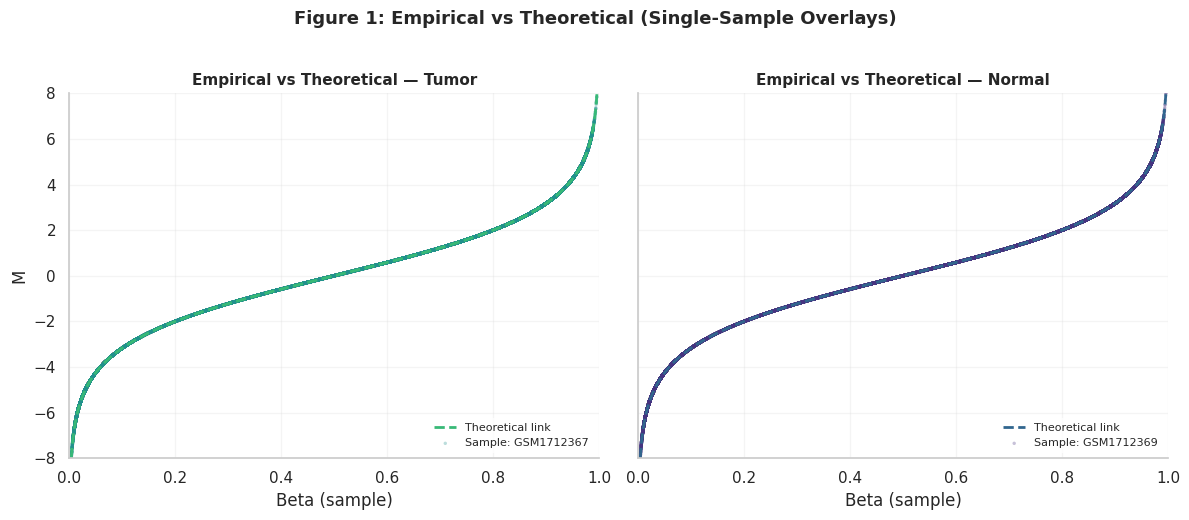

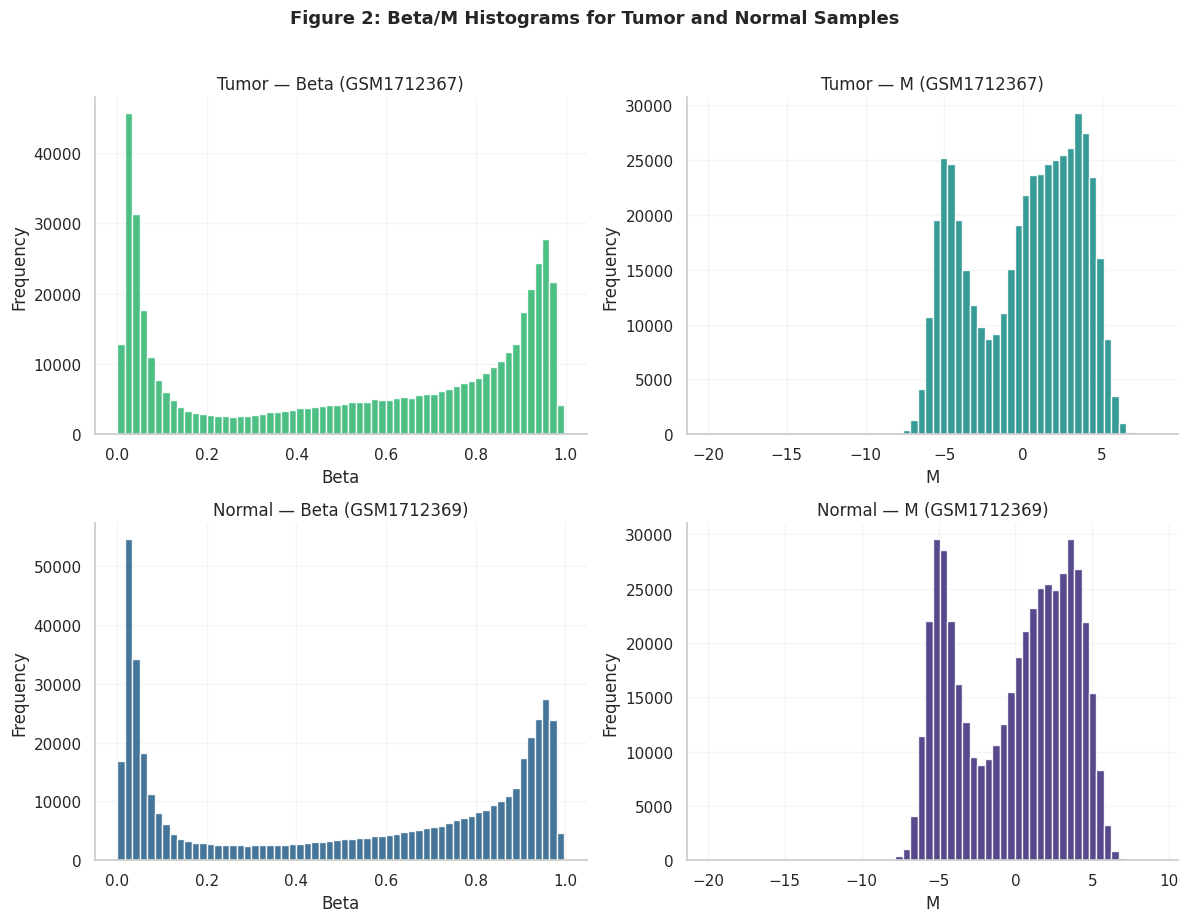

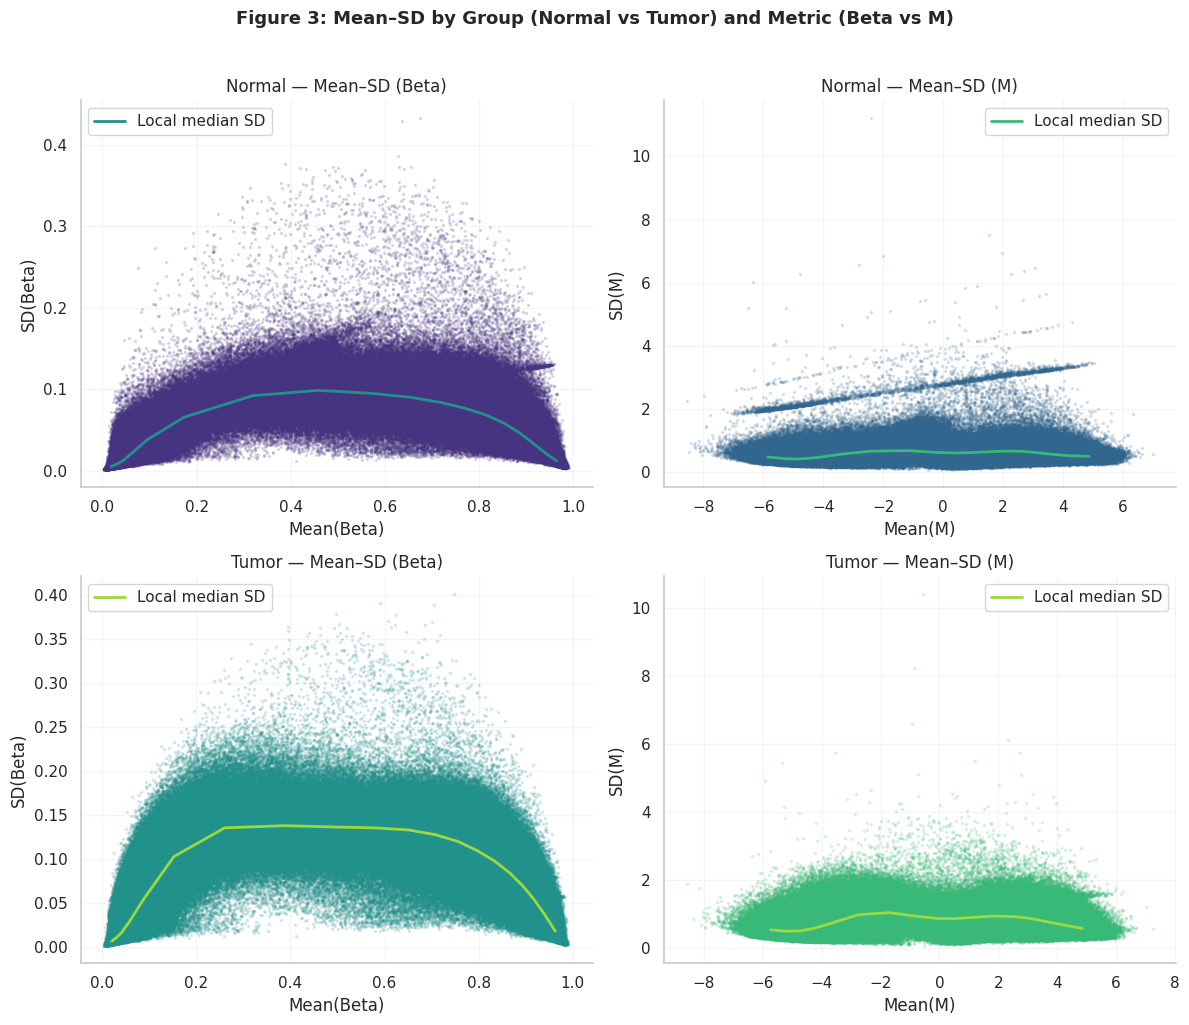

Saved figures:
 - fig1_empirical_vs_theoretical_dual.png
 - fig2_histograms_dual.png
 - fig3_mean_sd_bygroup.png


In [16]:
# Plot defaults
sns.set_theme(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["font.size"] = 10
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.facecolor"] = "white"
# Use viridis consistently
viridis = plt.cm.viridis(np.linspace(0.15, 0.85, 5))
cmap = plt.cm.viridis

# Small numeric constants (paper context; here only for Beta->M conversion)
EPS = 1e-6  # numeric stability when converting Beta -> M

# 1) Split features / labels
feature_cols = [c for c in raw_dataset.columns if c != 'label']
X = raw_dataset[feature_cols].astype(float).clip(0.0, 1.0).copy()  # enforce [0,1]
y = raw_dataset['label'].astype(int).copy()

print("Matrix shape (samples x CpGs):", X.shape)
print("Label counts:\n", y.value_counts(dropna=False))

# 2) Derived M-values from Beta (logit transform)
def compute_M_from_beta(beta, eps=EPS):
    beta = beta.astype(float).clip(eps, 1.0 - eps)
    return np.log2(beta / (1.0 - beta))

betas = X
Ms = compute_M_from_beta(betas)

# Keep aligned indices/columns
betas.index, Ms.index = X.index, X.index
betas.columns, Ms.columns = X.columns, X.columns

print("Computed matrices -> Beta:", betas.shape, " | M:", Ms.shape)

# 3) Pick the "typical sample" (paper: single sample for Fig.1–2)
#    - Prefer a tumor sample (label==2)
def pick_sample_for_label(labels, target_label):
    idx = labels[labels == target_label].index
    return idx[0] if len(idx) > 0 else None

tumor_sample  = pick_sample_for_label(y, target_label=2)
normal_sample = pick_sample_for_label(y, target_label=0)
print("Tumor sample for Fig.1–2:", tumor_sample)
print("Normal sample for Fig.1–2:", normal_sample)

# 4) Figure 1 — Relationship M vs Beta
#    - LEFT: Theoretical curve (M vs Beta)
#    - RIGHT: Empirical scatter (the chosen sample) + theoretical overlay
#    Save: fig1_relationship.png
def figure1_empirical_vs_theoretical_dual(betas_df, Ms_df, tumor_sample, normal_sample,
                                          max_points=80000, m_lim=(-8, 8)):
    sns.set_style("whitegrid")

    m_grid = np.linspace(m_lim[0], m_lim[1], 2000)
    beta_curve = (2.0 ** m_grid) / (1.0 + 2.0 ** m_grid)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

    def _panel(ax, sample_name, title_suffix, color_curve, color_scatter):
        bvals = betas_df.loc[sample_name].values
        mvals = Ms_df.loc[sample_name].values
        n = len(bvals)
        if n > max_points:
            idx = np.random.choice(n, size=max_points, replace=False)
            bvals = bvals[idx]
            mvals = mvals[idx]

        # Theoretical curve
        ax.plot(beta_curve, m_grid, linewidth=2, linestyle='--',
                color=color_curve, label="Theoretical link")

        # Empirical scatter
        ax.scatter(bvals, mvals, s=6, alpha=0.3, color=color_scatter,
                   edgecolors='none', label=f"Sample: {sample_name}")

        ax.set_xlim(0, 1)
        ax.set_ylim(*m_lim)
        ax.set_xlabel("Beta (sample)")
        ax.set_title(f"Empirical vs Theoretical — {title_suffix}",
                     fontsize=11, weight='semibold')
        ax.legend(loc="lower right", fontsize=8, frameon=True,
                  facecolor='white', edgecolor='none')

    if tumor_sample is not None:
        _panel(axes[0], tumor_sample, "Tumor", color_curve=viridis[3], color_scatter=viridis[2])
        axes[0].set_ylabel("M")

    if normal_sample is not None:
        _panel(axes[1], normal_sample, "Normal", color_curve=viridis[1], color_scatter=viridis[0])

    fig.suptitle("Figure 1: Empirical vs Theoretical (Single-Sample Overlays)",
                 fontsize=13, y=1.03, weight='bold')
    fig.tight_layout()
    sns.despine()
    plt.savefig("fig1_empirical_vs_theoretical_dual.png", dpi=300, bbox_inches="tight")
    plt.show()

    
# 5) Figure 2 — Histograms (single sample) side-by-side
#    - LEFT: Beta histogram
#    - RIGHT: M histogram
#    Save: fig2_histograms.png
def figure2_histograms_dual(betas_df, Ms_df, tumor_sample, normal_sample, bins=60):
    fig, axes = plt.subplots(2, 2, figsize=(12, 9))

    # Helper for consistent hist style
    def _hist(ax, data, title, xlabel, color):
        ax.hist(data, bins=bins, alpha=0.9, color=color, edgecolor='white')
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Frequency")
    
    if tumor_sample is not None:
        bt = betas_df.loc[tumor_sample].values
        mt = Ms_df.loc[tumor_sample].values
        _hist(axes[0, 0], bt, f"Tumor — Beta ({tumor_sample})", "Beta", viridis[3])
        _hist(axes[0, 1], mt, f"Tumor — M ({tumor_sample})", "M", viridis[2])
    
    if normal_sample is not None:
        bn = betas_df.loc[normal_sample].values
        mn = Ms_df.loc[normal_sample].values
        _hist(axes[1, 0], bn, f"Normal — Beta ({normal_sample})", "Beta", viridis[1])
        _hist(axes[1, 1], mn, f"Normal — M ({normal_sample})", "M", viridis[0])
    
    fig.suptitle("Figure 2: Beta/M Histograms for Tumor and Normal Samples",
                 fontsize=13, y=1.02, weight='bold')
    fig.tight_layout()
    sns.despine()
    plt.savefig("fig2_histograms_dual.png", dpi=300, bbox_inches="tight")
    plt.show()
    
# 6) Figure 3 — Mean–SD relation (across samples, pooled) side-by-side
#    - For each CpG (column): mean across samples vs SD across samples
#    - LEFT: Beta (expected heteroscedasticity near 0/1)
#    - RIGHT: M (approx. homoscedastic)
#    Save: fig3_mean_sd.png
def _binned_median_sd(means, sds, n_bins=20):
    df = pd.DataFrame({"mean": means, "sd": sds}).dropna().sort_values("mean")
    bins = np.array_split(df, n_bins)
    x = [b["mean"].median() for b in bins if len(b)]
    y = [b["sd"].median() for b in bins if len(b)]
    return np.array(x), np.array(y)

def figure3_mean_sd_bygroup(betas_df, Ms_df, labels, n_bins=20):
    B_norm = betas_df.loc[labels == 0]; M_norm = Ms_df.loc[labels == 0]
    B_tum = betas_df.loc[labels == 2]; M_tum = Ms_df.loc[labels == 2]

    def _mean_sd(B, M):
        return (B.mean(axis=0).values, B.std(axis=0, ddof=1).values,
                M.mean(axis=0).values, M.std(axis=0, ddof=1).values)

    nb_mean, nb_sd, nm_mean, nm_sd = _mean_sd(B_norm, M_norm)
    tb_mean, tb_sd, tm_mean, tm_sd = _mean_sd(B_tum, M_tum)

    nxb, nyb = _binned_median_sd(nb_mean, nb_sd, n_bins=n_bins)
    nxm, nym = _binned_median_sd(nm_mean, nm_sd, n_bins=n_bins)
    txb, tyb = _binned_median_sd(tb_mean, tb_sd, n_bins=n_bins)
    txm, tym = _binned_median_sd(tm_mean, tm_sd, n_bins=n_bins)

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    def _scatter(ax, mean, sd, xb, yb, title, xlabel, ylabel, color_points, color_line):
        ax.scatter(mean, sd, s=2, alpha=0.15, color=color_points)
        ax.plot(xb, yb, linewidth=2, label="Local median SD", color=color_line)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend()

    _scatter(axes[0, 0], nb_mean, nb_sd, nxb, nyb, "Normal — Mean–SD (Beta)",
             "Mean(Beta)", "SD(Beta)", viridis[0], viridis[2])
    _scatter(axes[0, 1], nm_mean, nm_sd, nxm, nym, "Normal — Mean–SD (M)",
             "Mean(M)", "SD(M)", viridis[1], viridis[3])
    _scatter(axes[1, 0], tb_mean, tb_sd, txb, tyb, "Tumor — Mean–SD (Beta)",
             "Mean(Beta)", "SD(Beta)", viridis[2], viridis[4])
    _scatter(axes[1, 1], tm_mean, tm_sd, txm, tym, "Tumor — Mean–SD (M)",
             "Mean(M)", "SD(M)", viridis[3], viridis[4])

    fig.suptitle("Figure 3: Mean–SD by Group (Normal vs Tumor) and Metric (Beta vs M)",
                 fontsize=13, y=1.02, weight='bold')
    fig.tight_layout()
    sns.despine()
    plt.savefig("fig3_mean_sd_bygroup.png", dpi=300, bbox_inches="tight")
    plt.show()

figure1_empirical_vs_theoretical_dual(betas, Ms, tumor_sample, normal_sample, max_points=80000, m_lim=(-8, 8))
figure2_histograms_dual(betas, Ms, tumor_sample, normal_sample, bins=60)
figure3_mean_sd_bygroup(betas, Ms, y, n_bins=20)

print("Saved figures:")
print(" - fig1_empirical_vs_theoretical_dual.png")
print(" - fig2_histograms_dual.png")
print(" - fig3_mean_sd_bygroup.png")

### Step 3 - Reducing the risk of false discovery enabling identification of biologically significant genome-wide methylation status using the HumanMethylation450 array [3]


**Purpose (what the paper set out to do).** The Illumina HumanMethylation450K array measures ~485k CpGs, but several **non-methylation genomic factors** (SNPs, INDELs, repeats, multi-mapping in the bisulfite genome) can distort probe hybridization and produce **noisy β-values**. Naeem *et al.* systematically benchmarked HM450K probes against **matched whole-genome bisulfite sequencing (WGBS)** to identify which probes yield reliable signals and to propose a **principled filtering strategy** that keeps biological signal while reducing false discoveries. High-quality probes showed very strong agreement with WGBS, providing an empirical “gold-standard” for comparisons.

#### How CpGs (probes) are filtered
Probe assessment occurs **before** methylation calling and follows a decision workflow:

1. **Uniqueness in bisulfite space.** Remove probes that map to multiple loci in the C→T–converted (bisulfite) genome (ambiguous source of signal). 
2. **Repetitive elements.** Remove probes overlapping RepeatMasker-annotated repeats (elevated β-discrepancy vs WGBS). 
3. **INDEL overlaps.** Annotate with dbSNP; INDEL-overlapping probes were generally **kept** by default because their performance was comparable to high-quality probes, with caveats depending on study design and population. 
4. **SNP overlaps.** If a probe contains **no** SNP, keep it; otherwise apply SNP-specific rules:
   5) **SNP at the interrogated CpG** → **remove** (inflates β error, can abolish the CpG). 
   6) **“Bisulfite-OK” SNPs** (C↔T changes not followed by G) → **tolerate**, as they are effectively T after bisulfite and do not degrade performance. 

The final recommended filter **removes ~39%** of probes (≈190,672) and **keeps ~294,840**, combining 172,587 “high-quality” probes with 122,253 “rescued” probes that evidence shows are not noisy despite initial flags. Genomic coverage remains broad; depletion is concentrated in a few regions (e.g., HLA on chr6) and island shelves.

#### Replication of Figure 4 — Within-tissue variability after filtering

**What the original shows.** For a homogeneous tissue cohort (blood), the authors compute **per-probe within-tissue standard deviation of β** and plot its **density** for three probe sets: **ALL**, **KEEP** (retained by the filter), and **DISCARD** (filtered out). The **KEEP** curve is **left-shifted** relative to **DISCARD**, indicating **lower within-tissue dispersion** and, therefore, **less technical noise**. Wilcoxon rank-based tests confirm the reduction in variability. 

**How this translates to my plots**

1. **What exactly is being plotted.**
For each CpG (a column), I compute the **within-group** standard deviation (SD) of β across samples *of the same tissue context* (Normal, Adjacent, Tumor). The SDs—one value per CpG—are then summarized by **kernel density curves**. I visualize them in two complementary ways:
* a **3×3 grid**: each row is a tissue group (Normal ▸ Adjacent ▸ Tumor), each column is a subset (ALL ▸ KEEP ▸ DISCARD). This isolates the shape of each distribution, making it easy to see how filtering changes dispersion within a group.
* a **triptych** (3 panels): one panel per group with **ALL/KEEP/DISCARD** **overlaid**. This emphasizes relative shifts between subsets under the same x-axis.

A **vertical dashed line at 0.10** marks the high-variance tail highlighted in Naeem *et al.* as enriched for problematic probes.



**Reading the 3×3 grid** (Group × Subset)

1. **Normal — ALL.**

* The density peaks close to **low SD** (near zero), indicating most CpGs are internally consistent across normal samples—what we expect for homogeneous tissue.
* A **long, thin right tail** shows a minority of CpGs with high within-group variability; these are the ones susceptible to technical/sequence confounders or genuine heterogeneity.

2. **Normal — KEEP.**

* The peak becomes **sharper** and sits **left** of the ALL distribution.
* The **mass beyond 0.10** (right of the dashed line) is **noticeably reduced**.
* Interpretation: Naeem’s KEEP rules effectively **remove noisy probes** while preserving the well-behaved core; this is the intended effect of the filter.

3. **Normal — DISCARD.**

* The curve is **flatter** with a **heavier tail**; density remains **elevated** past **0.10**.
* These are the probes the filter labels as risky (multi-mapping, repeats, SNP at CpG, etc.), and their larger SD corroborates that they inject noise if retained.

4. **Adjacent — ALL/KEEP/DISCARD.**

* The qualitative pattern mirrors Normal (KEEP left-shifted, DISCARD right-heavy).
* If the **Adjacent—ALL** curve shows a **slightly broader** main peak than Normal—ALL, that can reflect **biological heterogeneity** in adjacent tissue (field effects, stromal admixture).
* The **Adjacent—KEEP** panel should still suppress the high-variance tail relative to DISCARD, confirming that filtering helps even in borderline tissues.

5. **Tumor — ALL/KEEP/DISCARD.**

* Tumors commonly exhibit **greater intrinsic heterogeneity**. You may see:

  * a **broader main mode** for **Tumor—ALL**, and
  * a somewhat **fatter tail** than Normal at the same x-range.
* Crucially, **Tumor—KEEP** still shows a **left-shift** vs **Tumor—DISCARD**, indicating the filter reduces technical dispersion **even when biology is more variable**.
* **Tumor—DISCARD** tends to keep the strongest right-tail, consistent with the idea that problematic probe contexts exacerbate noise in already heterogeneous samples.

**Bottom line from the 3×3:**
Across all groups, **KEEP** ≪ **DISCARD** in the **high-SD tail** (to the right of 0.10). This replicates Naeem’s finding that the filter **systematically reduces within-tissue variability**—a proxy for technical noise—while retaining the bulk of informative probes.

Reading the **overlaid triptych** (ALL vs KEEP vs DISCARD within each group)

*Each panel compares the three subsets under the **same x-axis**, so **horizontal shifts** are meaningful*:

* **Normal (overlaid):** the **KEEP** curve is **visibly left-shifted** relative to **ALL** and **DISCARD**; the **area past 0.10** drops the most for **KEEP**. This is the clearest, most “textbook” replication of Figure 4.
* **Adjacent (overlaid):** KEEP remains left of DISCARD. If ALL sits between them, that indicates the mixture of retained and risky probes in ALL produces an intermediate dispersion profile.
* **Tumor (overlaid):** differences may be slightly **muted** if tumor heterogeneity dominates, but the **ordering remains** (KEEP left of DISCARD). Seeing this pattern persist in tumors is important: it shows the filter benefits **do not disappear** in challenging cohorts.

*What the **0.10** reference line adds*

Placing a vertical line at **SD = 0.10** makes the **tail enrichment** easy to read at a glance. In Naeem’s analysis, high-SD bins were disproportionately populated by probes affected by repeats, multi-mapping, or SNP-at-CpG. In my plots, **KEEP** consistently shows **less probability mass** beyond **0.10** than **DISCARD**—a **direct visual echo** of the paper’s conclusion that filtering curtails noisy variability.

In short, the shapes and relative positions of the curves in my figures **reproduce the core message of Figure 4**: Naeem’s evidence-based probe filter **reduces within-tissue β variability**, especially in the high-SD tail, thereby **lowering technical noise** and **improving reliability** for downstream analyses.

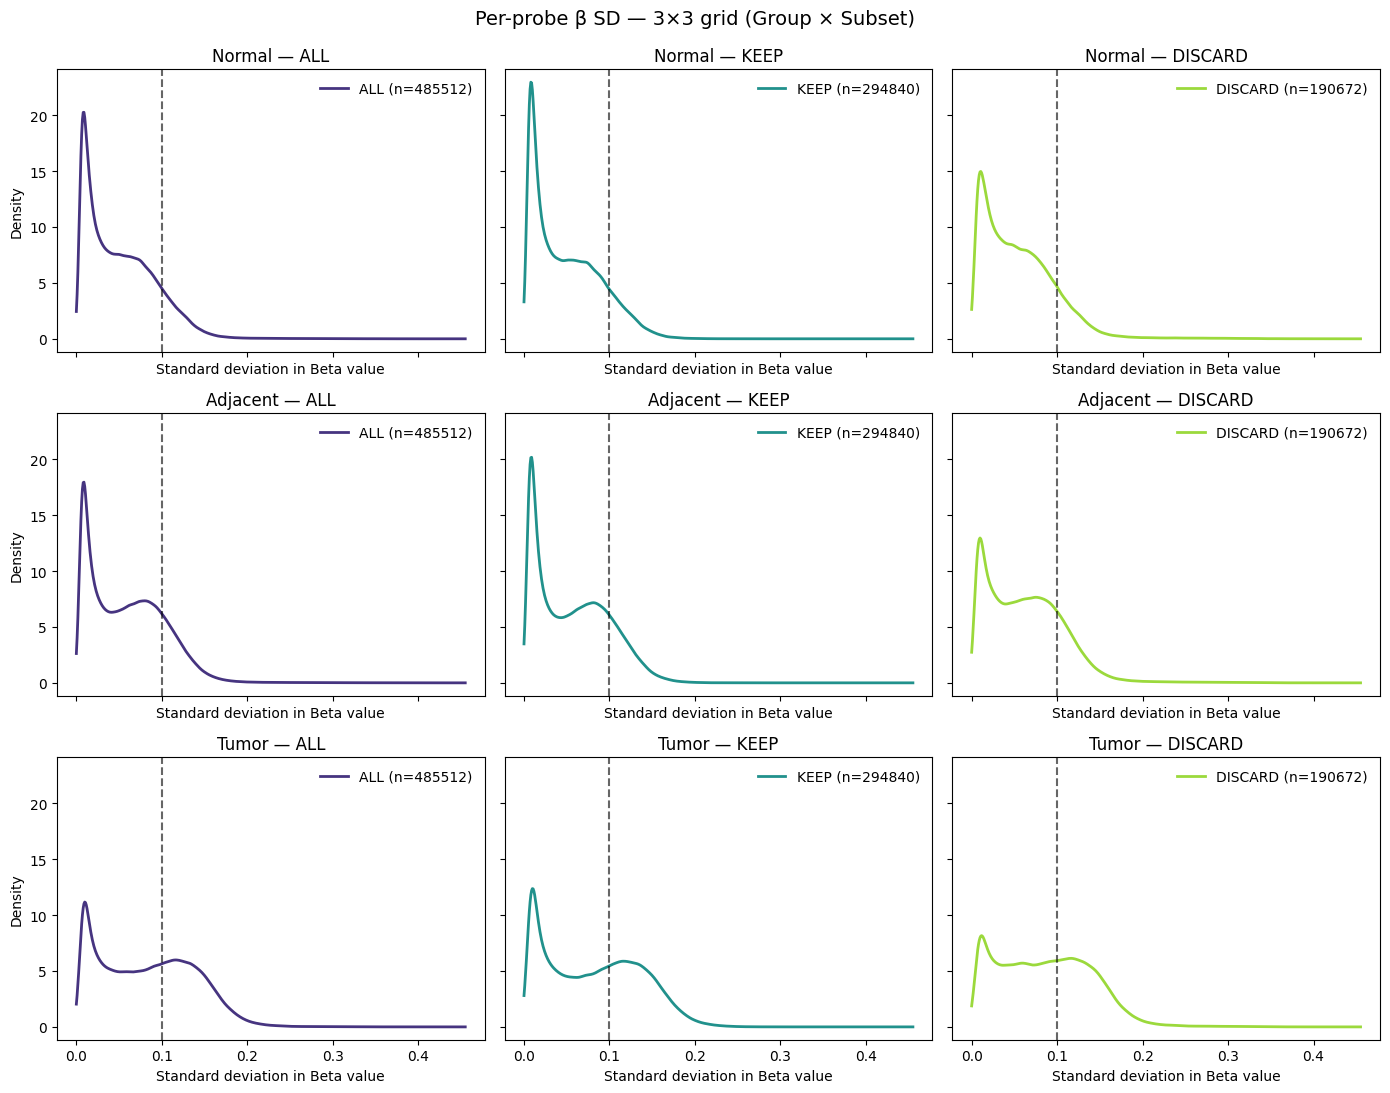

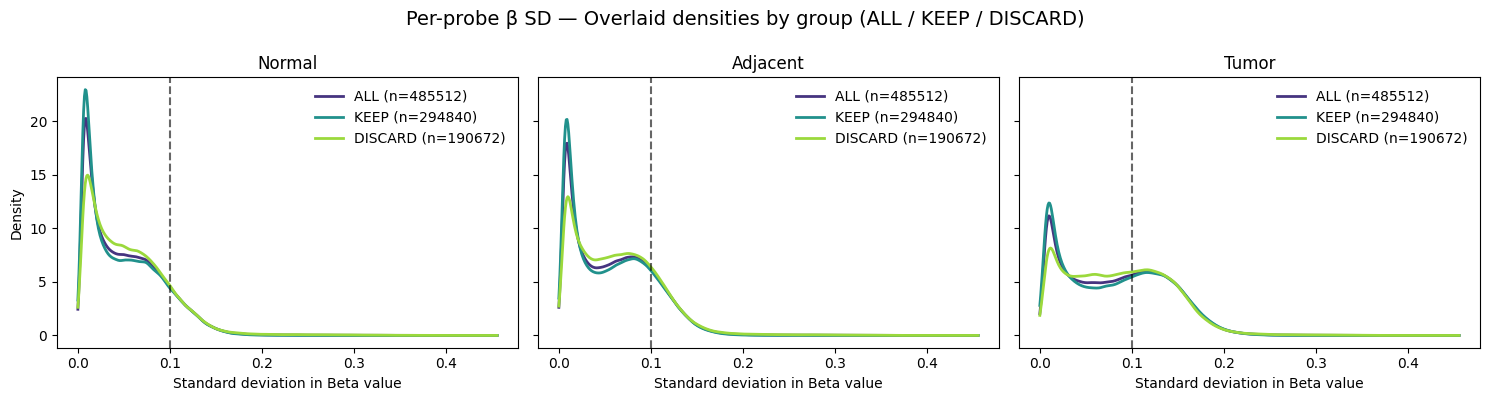

In [10]:
# CONFIGURATION
LABEL_COL = 'label'
NAEEM_CSV = "/kaggle/input/filtering-cpg-naeem/filtering_table.csv"
GROUPS = [0, 1, 2]
GROUP_NAMES = {0: "Normal", 1: "Adjacent", 2: "Tumor"}

SUBSETS = ["ALL", "KEEP", "DISCARD"]  # in order
LINE_AT = 0.10
MIN_POINTS_FOR_KDE = 5

# Colors (viridis) — fixed mapping for consistency across ALL figures
VIRIDIS = plt.cm.viridis(np.linspace(0.15, 0.85, 3))
COLOR_MAP = dict(zip(SUBSETS, VIRIDIS))


# LOAD NAEEM TABLE ONCE
naeem = pd.read_csv(NAEEM_CSV)
naeem.columns = [c.strip().lower() for c in naeem.columns]
probe_col = 'probe'
flag_col = 'flag(discard/keep)' if 'flag(discard/keep)' in naeem.columns else 'flag'
naeem[probe_col] = naeem[probe_col].astype(str).str.strip()
naeem[flag_col]  = naeem[flag_col].astype(str).str.strip().str.lower()

def kde_curve(series: pd.Series, xs: np.ndarray):
    """Return KDE y-values on xs grid, or None if too few points."""
    data = np.asarray(series.dropna().values)
    if data.size < MIN_POINTS_FOR_KDE:
        return None
    return gaussian_kde(data)(xs)

def compute_sets_and_sd(raw_dataset: pd.DataFrame, target_group: int):
    """
    Subset one group, build KEEP/DISCARD sets, compute per-probe SD (beta).
    Returns dict with sd_all, sd_keep, sd_discard (pd.Series), feature_cols (list).
    """
    group_df = raw_dataset[raw_dataset[LABEL_COL] == target_group].copy()
    feature_cols = [c for c in group_df.columns if c != LABEL_COL]

    if len(group_df) < 2 or len(feature_cols) == 0:
        return None

    keep_set = set(naeem.loc[naeem[flag_col] == 'keep', probe_col]) & set(feature_cols)
    discard_set = set(feature_cols) - keep_set

    X_beta = group_df[feature_cols]
    sd_all = X_beta.std(axis=0, ddof=1)
    sd_keep = sd_all[sd_all.index.isin(keep_set)]
    sd_discard = sd_all[sd_all.index.isin(discard_set)]

    return {
        "feature_cols": feature_cols,
        "sd_all": sd_all,
        "sd_keep": sd_keep,
        "sd_discard": sd_discard
    }

def compute_global_xs(per_group_results, force_min_max=(0.0, 0.25)):
    """
    Build a common x-grid for KDE across all panels, using the global max SD
    (at least 0.25 for a readable right margin).
    """
    global_sd_max = force_min_max[1]
    for res in per_group_results.values():
        if res is None: 
            continue
        if len(res["sd_all"]):
            global_sd_max = max(global_sd_max, float(res["sd_all"].max()))
    xs = np.linspace(force_min_max[0], global_sd_max * 1.05, 512)
    return xs

def plot_single_subset(ax, series: pd.Series, xs: np.ndarray, subset_name: str, title: str):
    """Plot one KDE (one subset) on one axis; add vertical line, labels, legend."""
    y = kde_curve(series, xs)
    if y is not None:
        ax.plot(xs, y, lw=2, color=COLOR_MAP[subset_name], label=f"{subset_name} (n={len(series)})")
    else:
        ax.text(0.5, 0.5, f"{subset_name}: not enough data", transform=ax.transAxes,
                ha='center', va='center', fontsize=9)

    ax.axvline(LINE_AT, ls="--", lw=1.5, color="k", alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("Standard deviation in Beta value")
    ax.grid(False)
    ax.legend(frameon=False)

def plot_overlaid_three(ax, sd_all: pd.Series, sd_keep: pd.Series, sd_discard: pd.Series,
                        xs: np.ndarray, group_name: str):
    """Overlay ALL/KEEP/DISCARD KDEs on one axis; legend on this axis."""
    for name, series in zip(SUBSETS, [sd_all, sd_keep, sd_discard]):
        y = kde_curve(series, xs)
        if y is not None:
            ax.plot(xs, y, lw=2, color=COLOR_MAP[name], label=f"{name} (n={len(series)})")
        else:
            ax.text(0.5, 0.5, f"{name}: not enough data", transform=ax.transAxes,
                    ha='center', va='center', fontsize=9)

    ax.axvline(LINE_AT, ls="--", lw=1.5, color="k", alpha=0.6)
    ax.set_title(group_name)
    ax.set_xlabel("Standard deviation in Beta value")
    ax.grid(False)
    ax.legend(frameon=False)

# PRECOMPUTE SDs FOR ALL GROUPS + COMMON X GRID
def prepare_results(raw_dataset: pd.DataFrame):
    per_group = {}
    for g in GROUPS:
        res = compute_sets_and_sd(raw_dataset, g)
        per_group[g] = res
    xs = compute_global_xs(per_group, force_min_max=(0.0, 0.25))
    return per_group, xs

# 9-PANEL GRID (3x3): each subplot = one subset for one group
def plot_grid_3x3(per_group, xs):
    fig, axes = plt.subplots(3, 3, figsize=(14, 11), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.12, hspace=0.22)

    # rows = groups in order Normal / Adjacent / Tumor
    # cols = subsets in order ALL / KEEP / DISCARD
    for row_idx, g in enumerate(GROUPS):
        res = per_group[g]
        group_name = GROUP_NAMES.get(g, str(g))
        if res is None:
            # Mark the whole row as unavailable
            for col_idx in range(3):
                ax = axes[row_idx, col_idx]
                ax.text(0.5, 0.5, f"{group_name}\n<2 samples or no data", ha="center", va="center")
                ax.set_axis_off()
            continue

        series_dict = {
            "ALL": res["sd_all"],
            "KEEP": res["sd_keep"],
            "DISCARD": res["sd_discard"]
        }

        for col_idx, subset in enumerate(SUBSETS):
            ax = axes[row_idx, col_idx]
            title = f"{group_name} — {subset}"
            plot_single_subset(ax, series_dict[subset], xs, subset, title)
            if col_idx == 0:
                ax.set_ylabel("Density")

    fig.suptitle("Per-probe β SD — 3×3 grid (Group × Subset)", fontsize=14, y=0.99)
    plt.tight_layout()
    plt.show()

# TRIPTYCH (1×3): each subplot = one group with ALL/KEEP/DISCARD overlaid
def plot_triptych_overlaid(per_group, xs):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    plt.subplots_adjust(wspace=0.05)

    for idx, g in enumerate(GROUPS):
        ax = axes[idx]
        res = per_group[g]
        group_name = GROUP_NAMES.get(g, str(g))
        if res is None:
            ax.text(0.5, 0.5, f"{group_name}\n<2 samples or no data", ha="center", va="center")
            ax.set_axis_off()
            continue

        plot_overlaid_three(ax, res["sd_all"], res["sd_keep"], res["sd_discard"], xs, group_name)
        if idx == 0:
            ax.set_ylabel("Density")
    fig.suptitle("Per-probe β SD — Overlaid densities by group (ALL / KEEP / DISCARD)",
                 fontsize=14, y=0.99)
    plt.tight_layout()
    plt.show()

per_group, xs = prepare_results(raw_dataset)
plot_grid_3x3(per_group, xs)
plot_triptych_overlaid(per_group, xs)

**CpG's Elimination**
After conducting the preliminary study, I will now effectively remove the CpGs mentioned in Paper **[3]**, resulting in a dataset with a `shape` of `(407, 294841)`.

In [5]:
def filter_cpgs_by_naeem_keep(raw_dataset: pd.DataFrame, naeem_csv_path: str,
                              label_col: str = 'label') -> pd.DataFrame:
    """
    Filter CpG columns from the dataset by keeping only those marked as 'keep'
    in the Reducing the risk of false discovery enabling identification of biologically significant
    genome-wide methylation status using the HumanMethylation450 array, Naeem et al. filtering file (Additional file 2).
    """

    # 1) Load the Naeem CSV file and normalize column names
    naeem = pd.read_csv(naeem_csv_path)
    naeem.columns = [c.strip().lower() for c in naeem.columns]

    # Helper function to find expected columns regardless of exact name variations
    def _pick(colnames, candidates):
        for cand in candidates:
            if cand in colnames:
                return cand
        raise KeyError(f"Required column not found. Expected one of: {candidates}")

    # Identify the key columns
    probe_col = _pick(naeem.columns, ['probe'])
    flag_col  = _pick(naeem.columns, ['flag(discard/keep)', 'flag', 'flag_discard_keep'])

    # Clean probe IDs and flag values (strip spaces and lower case)
    naeem[probe_col] = naeem[probe_col].astype(str).str.strip()
    naeem[flag_col]  = naeem[flag_col].astype(str).str.strip().str.lower()

    # 2) Extract the set of probes marked as 'keep'
    keep_set = set(naeem.loc[naeem[flag_col] == 'keep', probe_col])

    # 3) Separate feature columns from the label column
    if label_col not in raw_dataset.columns:
        raise KeyError(f"Label column '{label_col}' not found in the dataset.")
    feature_cols = [c for c in raw_dataset.columns if c != label_col]

    # 4) Match CpG names between dataset and Naeem list (normalize for safety)
    feature_cols_norm = [str(c).strip() for c in feature_cols]
    col_map = {orig: norm for orig, norm in zip(feature_cols, feature_cols_norm)}
    dataset_cpg_norm = set(feature_cols_norm)
    kept_norm = dataset_cpg_norm.intersection(keep_set)

    # 5) Retrieve the original column names corresponding to the kept CpGs
    kept_original = [orig for orig, norm in col_map.items() if norm in kept_norm]

    # 6) Logging and basic diagnostics
    total_before = len(feature_cols)
    total_after  = len(kept_original)
    missing_in_dataset = len(keep_set - dataset_cpg_norm)
    print(f"[Naeem keep-filter] Initial CpGs: {total_before} | "
          f"Kept: {total_after} | "
          f"'Keep' probes not found in dataset: {missing_in_dataset}")

    # 7) Return filtered dataset (same column order, label intact)
    filtered = raw_dataset[[label_col] + kept_original].copy()
    return filtered

naeem_csv_path = "/kaggle/input/filtering-cpg-naeem/filtering_table.csv"
raw_dataset = filter_cpgs_by_naeem_keep(raw_dataset, naeem_csv_path, label_col='label')
print(raw_dataset.shape)
raw_dataset.head()

[Naeem keep-filter] Initial CpGs: 485512 | Kept: 294840 | 'Keep' probes not found in dataset: 0
(407, 294841)
(407, 485513)


ID_REF,label,cg00000029,cg00000108,cg00000165,cg00000236,cg00000289,cg00000292,cg00000363,cg00000714,cg00000721,...,ch.X.747556F,ch.X.7566543R,ch.X.87262228F,ch.X.881064F,ch.X.881546R,ch.X.92448175R,ch.X.92543860F,ch.X.938089F,ch.X.97129969R,ch.X.97651759F
GSM1712367,2,0.258254,0.986116,0.247964,0.902621,0.481930,0.839584,0.205147,0.103498,0.972847,...,0.033231,0.035893,0.009650,0.026025,0.024220,0.027600,0.010835,0.010076,0.002110,0.008278
GSM1712368,1,0.197553,0.981426,0.343906,0.868874,0.531370,0.702531,0.124332,0.067254,0.965974,...,0.039669,0.074744,0.017769,0.016444,0.091548,0.196777,0.019340,0.005971,0.034879,0.051845
GSM1712369,0,0.275187,0.972137,0.216030,0.837979,0.526388,0.761244,0.185712,0.096510,0.977240,...,0.013751,0.072978,0.017172,0.045140,0.089219,0.226931,0.010249,0.016593,0.058810,0.018309
GSM1712370,2,0.150849,0.984434,0.576088,0.931236,0.602277,0.677764,0.498028,0.055394,0.984695,...,0.016699,0.068643,0.019118,0.021037,0.023440,0.129855,0.014357,0.006860,0.029233,0.016153
GSM1712371,2,0.240538,0.987393,0.616293,0.915173,0.416164,0.791098,0.525042,0.098411,0.970629,...,0.012656,0.039577,0.008502,0.014266,0.016902,0.063910,0.010126,0.000016,0.023234,0.011282


### Step X —
TEST STATISTICO SUI BETA 

 Cercare di capire bene come fare, probabilmente test è una cosa sensata come ti ha detto ric, ma bisogna pensare bene come e cosa dimostrare.

### Step X — Conversion to M-Value

Alla fine dello studio, si modifica il dataset originale per passare da beta-value a M-value per seguire, dopo averne dimostrato la mecessità, i paper [2] etc.

**Beta-value ($\beta$).** Fraction of methylated signal over total signal, stabilized with a small offset ($\alpha$) in the denominator:
$$
\beta_i := \frac{\max\big(y^{(M)}_i,0\big)}{\max\big(y^{(M)}_i,0\big)+\max\big(y^{(U)}_i,0\big)+\alpha},
\qquad 0\le \beta_i \le 1.
$$

**M-value (M).** Log-ratio (base 2) of methylated to unmethylated intensities with a small offset ($\alpha$) in each channel:
$$
M_i := \log_2\left(\frac{\max\big(y^{(M)}_i,0\big)+\alpha}{\max\big(y^{(U)}_i,0\big)+\alpha}\right)\in(-\infty,\infty).
$$

**Link between ($\beta$) and (M)**:
$$
\beta_i := \frac{2^{M_i}}{1+2^{M_i}}
\quad\Longleftrightarrow\quad
M_i := \log_2\left(\frac{\beta_i}{1-\beta_i}\right).
$$

(LO HAI MOTIVATO, MA NON HAI ANCORA SALVATO IN DATASET CON M-VALUE (DA FARE QUANDO HAI DECISO CHE CPG MANTENERE -  FORSE COME ULTIMA COSA)


In [11]:
# 2) Derived M-values from Beta (logit transform)
def compute_M_from_beta(beta, eps=EPS):
    beta = beta.astype(float).clip(eps, 1.0 - eps)
    return np.log2(beta / (1.0 - beta))

betas = X
Ms = compute_M_from_beta(betas)

# Keep aligned indices/columns
betas.index, Ms.index = X.index, X.index
betas.columns, Ms.columns = X.columns, X.columns

print("Computed matrices -> Beta:", betas.shape, " | M:", Ms.shape)

NameError: name 'EPS' is not defined

## References

[1] National Center for Biotechnology Information, “GSE69914 on GEO Datasets,” *Gene Expression Omnibus (GEO)*, 2015. [Online]. Available: [https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE69914](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE69914). 

[2] P. Du, X. Zhang, C. Huang, N. Jafari, W. A. Kibbe, L. Hou, and S. M. Lin, “Comparison of beta-value
and m-value methods for quantifying methylation levels by microarray analysis,” BMC Bioinformatics,
vol. 11, p. 587, 2010, [Online]. [Online]. Available: https://doi.org/10.1186/1471-2105-11-587

[3] H. Naeem, N. C. Wong, Z. Chatterton, M. K. H. Hong, J. S. Pedersen, N. M. Corcoran, C. M.
Hovens, and G. Macintyre, “Reducing the risk of false discovery enabling identification of biologically
significant genome-wide methylation status using the humanmethylation450 array,” BMC Genomics,
vol. 15, p. 51, 2014. [Online]. Available: http://www.biomedcentral.com/1471-2164/15/51